# Create Environment

In [142]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm import tqdm

global N

N=100

global T
global target
T=8.5
target=5.4482
global w
w=np.pi*2/23.7

global delta_t
delta_t=T/N

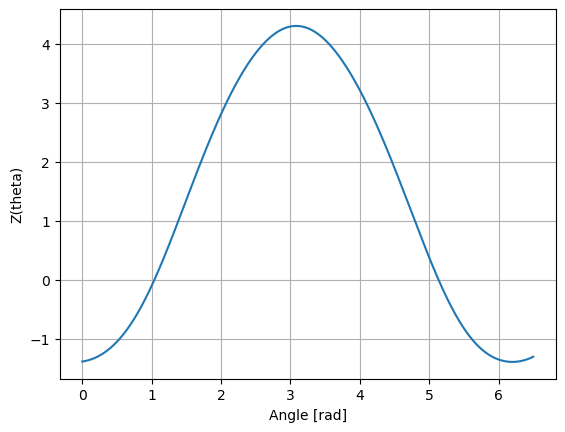

In [143]:
def Z(theta):
    return 1.417-2.9006*np.cos(theta)+0.0217*np.cos(2*theta)+0.0603*np.cos(3*theta)+0.02148*np.cos(4*theta)+0.1624*np.sin(theta)
    +0.4248*np.sin(theta)+0.0553*np.sin(3*theta)-0.0126*np.sin(4*theta)

#check the correctness of Z
x = np.linspace(0, 6.5, 1001)
plt.plot(x, Z(x))
plt.xlabel('Angle [rad]')
plt.ylabel('Z(theta)')
plt.grid()
plt.show()

In [144]:
def next_step_and_reward(theta_k,u_k):
    theta_new=theta_k+delta_t*(w+Z(theta_k)*u_k)
    return theta_new, -(theta_new-target)**2

def reward(theta_k):
    return -(theta_k-target)**2



# Learning Settings

In [145]:
global lr
lr=0.01
global eps
eps=0.1
global max_u
max_u=2
global precision
precision=0.0002
def exploration():
    a=np.random.uniform()
    if a<eps:
        return True
    else:
        return False

def find_max(cand):
    ind=np.argmax(cand)
    possible=np.linspace(0, max_u, int(max_u/precision+1))
    return possible[ind]
    
def decide_u(theta,cand,init=False):
    explo=exploration()
    if init or explo:
        possible=np.linspace(0, max_u,  int(max_u/precision+1))
        return(possible[np.random.randint( int(max_u/precision+1))])
    else:
        return(find_max(cand))
    
def generate_cand(theta):
    possible=np.linspace(0, max_u,  int(max_u/precision+1))
    cand=[]
    for i in range( int(max_u/precision+1)):
        cand.append([theta,possible[i]])
    return np.array(cand)

history_su=np.array([[]])
history_r=np.array([])
possible_u=np.linspace(0, max_u,  int(max_u/precision+1))

# Simulation


In [146]:
num_iter=100

theta_result=[]
for iterr in tqdm(range(num_iter)):
    #initialize
    theta=1.4918
    u_t=[]
    theta_t=[1.4918]
    for time in range(N+1):
        if iterr==0:
            candidates_u=[]
            u_k = decide_u(theta,candidates_u,init=True)
            theta_new, r = next_step_and_reward(theta,u_k)
            if time==0:
                history_su = np.array([theta,u_k]).reshape(1,-1)
            else:
                history_su = np.concatenate((history_su, np.array([theta,u_k]).reshape(1,-1)))
            history_r = np.concatenate((history_r,np.array([r])))
            theta=theta_new
            u_t.append(u_k)
        else:            
            x_cand = generate_cand(theta)
            candidates_u, std_u = gpr.predict(x_cand.reshape(-1,2), return_std=True)
            u_k = decide_u(theta,candidates_u)
            theta_new, r = next_step_and_reward(theta,u_k)
            history_su = np.concatenate((history_su, np.array([theta,u_k]).reshape(-1,2)))
            history_r = np.concatenate((history_r,np.array([r])))
            theta = theta_new
            u_t.append(u_k)
            theta_t.append(theta)
    gpr = GaussianProcessRegressor(alpha=1e-8).fit(history_su, history_r.reshape(-1,1))
    print("theta =",theta)
    theta_result.append(theta)
    if abs(r)<1e-8:
        break
    #print(history_su.shape)
    #print(u_t)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

theta = 5.249913538922395


  2%|█▋                                                                                | 2/100 [00:04<03:31,  2.16s/it]

theta = 5.426751300813423


  3%|██▍                                                                               | 3/100 [00:12<07:21,  4.55s/it]

theta = 5.447734606948631


  4%|███▎                                                                              | 4/100 [00:24<12:02,  7.53s/it]

theta = 5.448417390635417


  5%|████                                                                              | 5/100 [00:42<17:22, 10.97s/it]

theta = 5.437803947109343


  5%|████                                                                              | 5/100 [01:05<20:49, 13.16s/it]

theta = 5.448191116953481


# Results

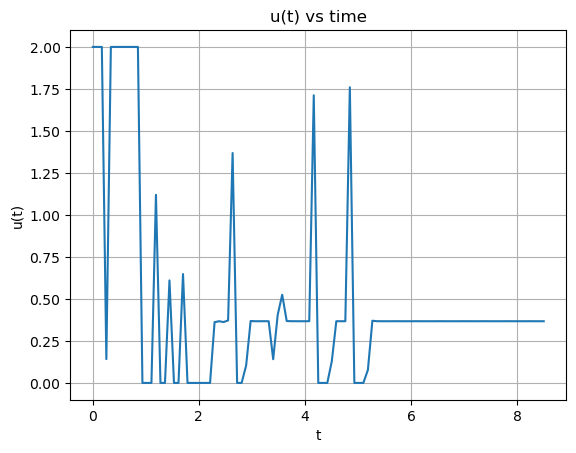

In [153]:
x = np.linspace(0, T, N+1)
plt.plot(x, u_t)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

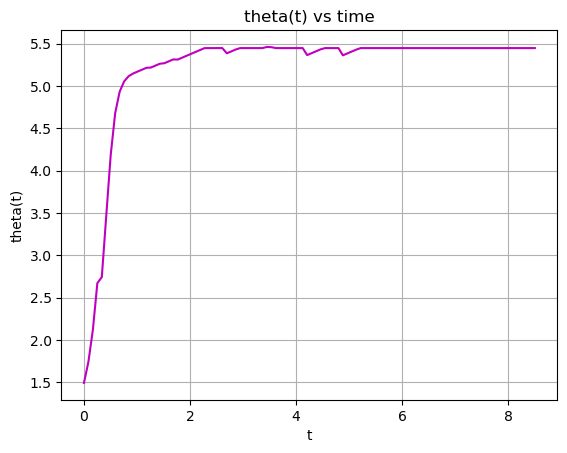

In [155]:
x = np.linspace(0, T, N+2)
plt.plot(x, theta_t, color='m')
plt.xlabel('t')
plt.ylabel('theta(t)')
plt.title("theta(t) vs time")
plt.grid()
plt.show()

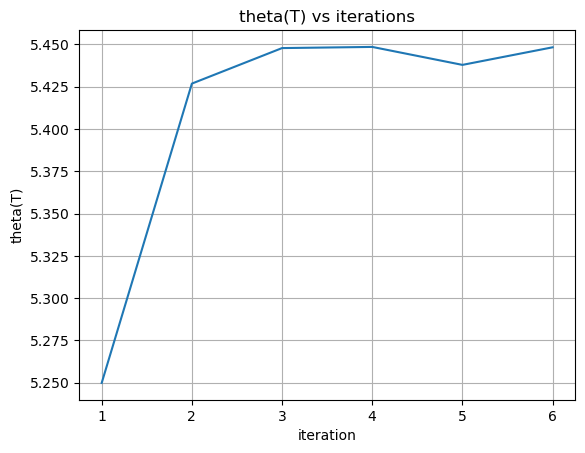

In [150]:
num_iter=len(theta_result)

x = np.linspace(1, num_iter, num_iter)
plt.plot(x, theta_result)
plt.xlabel('iteration')
plt.ylabel('theta(T)')
plt.title("theta(T) vs iterations")
plt.grid()
plt.show()